In [1]:
#30DayMapChallenge Day 9: Space
#Going back to Voronoi diagrams, because they're always cool, I managed to blend data from @MetricaSports
#and the @mplsoccer_dev animation tutorial with the
#mpl voronoi diagram tutorial to create an animated voronoi diagram!

In [2]:
import numpy as np
import pandas as pd
from matplotlib import animation
from matplotlib import pyplot as plt

from mplsoccer import Pitch, FontManager, Sbopen, add_image
from urllib.request import urlopen
from PIL import Image

In [3]:
import geopandas as gpd
import contextily as ctx
from shapely.ops import unary_union, cascaded_union

In [4]:
# load away data
LINK1 = ('https://raw.githubusercontent.com/metrica-sports/sample-data/master/'
         'data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv')
df_away = pd.read_csv(LINK1, skiprows=2)
df_away.sort_values('Time [s]', inplace=True)

# load home data
LINK2 = ('https://raw.githubusercontent.com/metrica-sports/sample-data/master/'
         'data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv')
df_home = pd.read_csv(LINK2, skiprows=2)
df_home.sort_values('Time [s]', inplace=True)

In [5]:
# column names aren't great so this sets the player ones with _x and _y suffixes
def set_col_names(df):
    """ Renames the columns to have x and y suffixes."""
    cols = list(np.repeat(df.columns[3::2], 2))
    cols = [col+'_x' if i % 2 == 0 else col+'_y' for i, col in enumerate(cols)]
    cols = np.concatenate([df.columns[:3], cols])
    df.columns = cols


set_col_names(df_away)
set_col_names(df_home)

In [6]:
# get a subset of the data (6 seconds)
df_away = df_away[(df_away['Time [s]'] >= 1804) & (df_away['Time [s]'] < 1810)].copy()
df_home = df_home[(df_home['Time [s]'] >= 1804) & (df_home['Time [s]'] < 1810)].copy()

In [7]:
# split off a df_ball dataframe and drop the ball columns from the player dataframes
df_ball = df_away[['Period', 'Frame', 'Time [s]', 'Ball_x', 'Ball_y']].copy()
df_home.drop(['Ball_x', 'Ball_y'], axis=1, inplace=True)
df_away.drop(['Ball_x', 'Ball_y'], axis=1, inplace=True)
df_ball.rename({'Ball_x': 'x', 'Ball_y': 'y'}, axis=1, inplace=True)

In [8]:
# convert to long form from wide form
def to_long_form(df):
    """ Pivots a dataframe from wide-form (each player as a separate column) to long form (rows)"""
    df = pd.melt(df, id_vars=df.columns[:3], value_vars=df.columns[3:], var_name='player')
    df.loc[df.player.str.contains('_x'), 'coordinate'] = 'x'
    df.loc[df.player.str.contains('_y'), 'coordinate'] = 'y'
    df = df.dropna(axis=0, how='any')
    df['player'] = df.player.str[6:-2]
    df = (df.set_index(['Period', 'Frame', 'Time [s]', 'player', 'coordinate'])['value']
          .unstack()
          .reset_index()
          .rename_axis(None, axis=1))
    return df


df_away = to_long_form(df_away)
df_home = to_long_form(df_home)

In [9]:
#Away positioning
df_away.head()

,Period,Frame,Time [s],player,x,y
0,1,45100,1804.0,15,0.56861,0.53047
1,1,45100,1804.0,16,0.55751,0.72218
2,1,45100,1804.0,17,0.51822,0.90578
3,1,45100,1804.0,18,0.53894,0.38481
4,1,45100,1804.0,19,0.43683,0.63887


In [10]:
#Home positioning
df_home.head()

,Period,Frame,Time [s],player,x,y
0,1,45100,1804.0,1,0.54843,0.99513
1,1,45100,1804.0,10,0.46684,0.87166
2,1,45100,1804.0,11,0.09109,0.55038
3,1,45100,1804.0,2,0.28476,0.94966
4,1,45100,1804.0,3,0.28830,0.69489


In [11]:
#Ball positioning
df_ball.head()

,Period,Frame,Time [s],x,y
45099,1,45100,1804.00,NaN,NaN
45100,1,45101,1804.04,NaN,NaN
45101,1,45102,1804.08,NaN,NaN
45102,1,45103,1804.12,NaN,NaN
45103,1,45104,1804.16,NaN,NaN


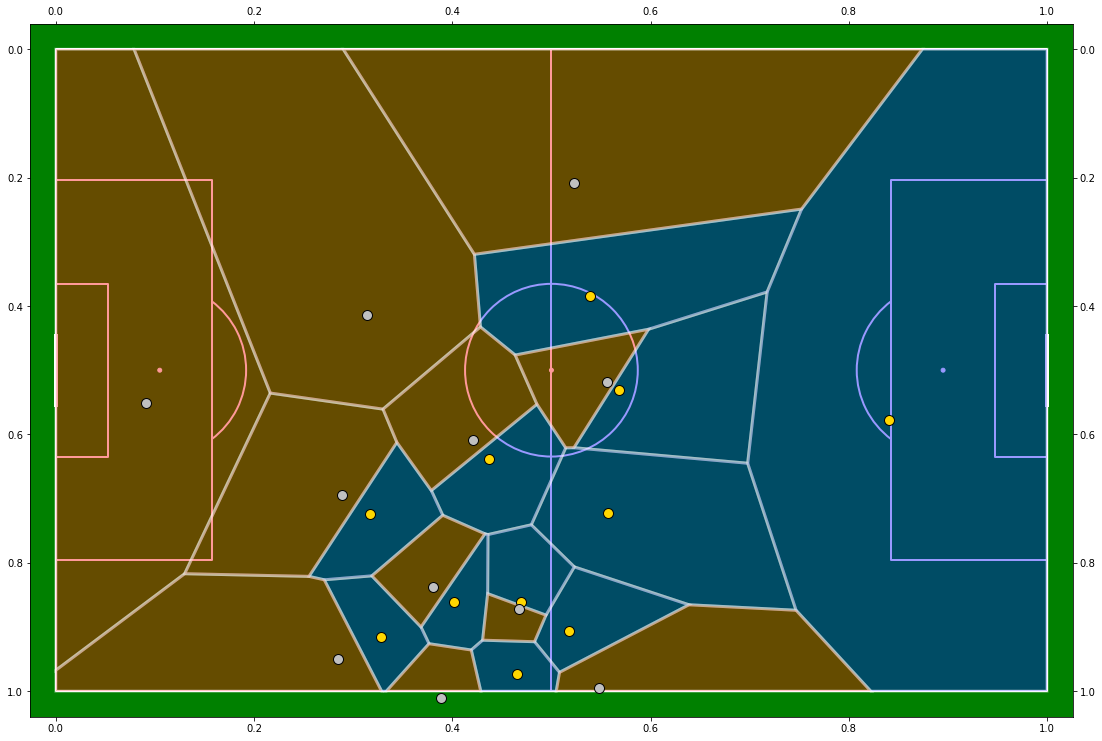

MovieWriter ffmpeg unavailable; using Pillow instead.


In [ ]:
# First set up the figure, the axis
#pitch = Pitch(pitch_type='metricasports', goal_type='line', pitch_width=68, pitch_length=105)
pitch = Pitch(pitch_type ="metricasports", #orientation = "horizontal",
              pitch_color ="green",line_color="white",#constrained_layout = False, view = 'half',
              axis =True, label = True, tick=True, pitch_width=68, pitch_length=105)
fig, ax = pitch.draw(figsize=(16, 10.4))

# then setup the pitch plot markers we want to animate
marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
ball, = ax.plot([], [], ms=6, markerfacecolor='w', zorder=3, **marker_kwargs)
away, = ax.plot([], [], ms=10, markerfacecolor='#FFD700', **marker_kwargs)  # red/maroon
home, = ax.plot([], [], ms=10, markerfacecolor='#C0C0C0', **marker_kwargs)  # purple

gov = list(np.zeros((11,),dtype=int))
opp = list(np.ones((11,),dtype=int))
# animation function
def animate(i):
    """ Function to animate the data. Each frame it sets the data for the players and the ball."""
    # set the ball data with the x and y positions for the ith frame
    ball.set_data(df_ball.iloc[i, 3], df_ball.iloc[i, 4])
    # get the frame id for the ith frame
    frame = df_ball.iloc[i, 1]
    # set the player data using the frame id
    away.set_data(df_away.loc[df_away.Frame == frame, 'x'],
                  df_away.loc[df_away.Frame == frame, 'y'])
    home.set_data(df_home.loc[df_home.Frame == frame, 'x'],
                  df_home.loc[df_home.Frame == frame, 'y'])
    fin = pd.DataFrame({
        'x':df_home.loc[df_home.Frame == frame, 'x'].append(df_away.loc[df_away.Frame == frame, 'x']),
        'y':df_home.loc[df_home.Frame == frame, 'y'].append(df_away.loc[df_away.Frame == frame, 'y']),
        'team': gov + opp
    })
    team1, team2 =pitch.voronoi(fin.x,fin.y,fin.team)
    t1 = pitch.polygon(team1,ax=ax,fc='blue',ec='white',lw=3,alpha=.4)
    t2 = pitch.polygon(team2,ax=ax,fc='red',ec='white',lw=3,alpha=.4)
    #t1.set_data(team1)
    #t2.set_data(team2)
    return ball, away, home


# call the animator, animate so 25 frames per second
anim = animation.FuncAnimation(fig, animate, frames=len(df_ball), interval=50, blit=True)

plt.show()

#Animation save as gif
anim.save('finalday9.gif', dpi=150, fps=25,
            #extra_args=['-vcodec', 'libx264'],
            savefig_kwargs={'pad_inches':0, 'facecolor':'#457E29'})
